In [19]:
!pip install hmmlearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [20]:
import os
import pickle
import pandas as pd
from pandas import read_csv
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, KFold
import hmmlearn
from hmmlearn import hmm
from matplotlib.patches import Arrow



In [21]:
error_ignore = np.seterr(divide='ignore', invalid='ignore')

hand_gesture_list = ['MoveDown','MoveLeft','MoveRight','MoveUp','Press','ZoomIn','ZoomOut']

In [22]:
def dataset_prep(file_path):
    csv_data = read_csv(file_path)
    sub_data_frame_obj = {}
    x = []
    y = []
    
    for gesture in hand_gesture_list:
        feature_list = []
        new_df = csv_data.loc[csv_data['Gesture'] == gesture].copy()
        sub_data_frame_obj[gesture] = new_df
        for i in range(30):
            LC_X = 'LC_X_' + str(i+1)
            LC_Y = 'LC_Y_' + str(i+1)
            RC_X = 'RC_X_' + str(i+1)
            RC_Y = 'RC_Y_' + str(i+1)
            inter_feature_array = new_df[[LC_X, LC_Y, RC_X, RC_Y]].to_numpy()
            mn = inter_feature_array.min(0)
            mx = inter_feature_array.max(0)
            inter_feature_array = inter_feature_array - mn
            inter_feature_array = inter_feature_array / (mx - mn)
            inter_feature_array = np.nan_to_num(inter_feature_array)
            feature_list.append(inter_feature_array)
        feature_list = np.transpose(np.asarray(feature_list),(1,0,2))
        x.extend(feature_list)
        gesture_label = np.full(len(feature_list), gesture)
        y.extend(gesture_label)
        
    x = np.stack(x)
    y = np.asarray(y)
    
    return (x,y)

In [23]:
#Hidden Markov Model
#Define functions to train and test using hmmlearn (https://hmmlearn.readthedocs.io/en/stable/index.html)
#Get random List of components
def get_components():
    
    components = set()
    while (len(components) < 5):
        components.add(np.random.randint(1,50))
    return list(components)

#Method to train and save 7 different models 
def train_model(X, Y, save_models=True):
    
    component_list = get_components()
    model_list = []
    max_score = -np.inf
    best_component = None
    
    for gesture in hand_gesture_list:
        
        print('Gesture: ',gesture)
        
        model_input = X[Y == gesture]
        _state = np.random.RandomState(0)
        train_X, test_X = train_test_split(model_input, test_size=0.1,shuffle=True,random_state=_state)
        k_fold_validation = KFold(n_splits=10, random_state=_state, shuffle=True)
        
        print('-----------------------------------------------')
        
        for component in component_list:
        
            score_list = []
            for train_index, validation_index in k_fold_validation.split(train_X):
                
                X_train, X_test = train_X[train_index], train_X[validation_index]
                
                model = hmm.GaussianHMM(n_components=component, covariance_type='spherical', random_state=_state)
                model.fit(X_train.reshape(-1, 4), lengths=[30] * len(X_train))
                score = model.score(X_test.reshape(-1, 4))
                score_list.append(score)
                
            score = np.mean(score_list)
            if score > max_score:
                max_score = score
                best_component = component
            
            print('| Number Of Components = {}   | Score = {:.2f} |'.format(component, score))

        hmm_model = hmm.GaussianHMM(n_components=best_component, covariance_type='spherical', random_state=_state)
        hmm_model.fit(train_X.reshape(-1, 4), lengths=[30] * len(train_X))
        model_list.append(model)
        print('-----------------------------------------------')
        
    if save_models:
        with open('hmm_models.txt', 'wb') as f:
            pickle.dump(model_list, f)

    return model_list

def predict_model(X, model_list=None):
    
    if model_list is None:
        with open('hmm_models.txt', 'rb') as f:
            model_list = pickle.load(f)

    likelihood = [m.score(X) for m in models]
    pred = np.argmax(likelihood)
    return pred


def test_model(X, Y, model_list=None):

    prediction = [hand_gesture_list[predict_model(_x, models)] for _x in X]
    prediction = np.asarray(prediction)
    correct = (prediction == Y).sum()

    return correct / len(X)       

In [24]:
#Training all 7 models with different combinations of hyperparameters to find best fit combination
(input_x, output_y) = dataset_prep('Original_Dataset.csv')
models = train_model(input_x, output_y)

Gesture:  MoveDown
-----------------------------------------------
| Number Of Components = 3   | Score = 340.98 |
| Number Of Components = 6   | Score = 496.23 |
| Number Of Components = 45   | Score = 578.39 |
| Number Of Components = 15   | Score = 519.42 |
| Number Of Components = 49   | Score = 599.26 |
-----------------------------------------------
Gesture:  MoveLeft
-----------------------------------------------
| Number Of Components = 3   | Score = 545.58 |
| Number Of Components = 6   | Score = 725.81 |
| Number Of Components = 45   | Score = 998.90 |
| Number Of Components = 15   | Score = 831.97 |
| Number Of Components = 49   | Score = 1000.04 |
-----------------------------------------------
Gesture:  MoveRight
-----------------------------------------------
| Number Of Components = 3   | Score = 545.13 |
| Number Of Components = 6   | Score = 646.54 |
| Number Of Components = 45   | Score = 868.93 |
| Number Of Components = 15   | Score = 814.22 |
| Number Of Component

In [25]:
#Testing the trained model for liklihood value
for gesture in hand_gesture_list:
    
    _model = output_y == gesture
    _x = input_x[_model]
    _y = output_y[_model]
    print(gesture, ' | Accuracy = {:.2f} %'.format(test_model(_x, _y) * 100))

MoveDown  | Accuracy = 100.00 %
MoveLeft  | Accuracy = 94.00 %
MoveRight  | Accuracy = 100.00 %
MoveUp  | Accuracy = 98.00 %
Press  | Accuracy = 98.00 %
ZoomIn  | Accuracy = 100.00 %
ZoomOut  | Accuracy = 100.00 %


In [26]:
#Sampling from HMM Model
def sample_model(model, n_samples):
    
    _state = model.random_state

    startprob_cdf = np.cumsum(model.startprob_)
    currstate = (startprob_cdf > _state.rand()).argmax()
    transmat_cdf = np.cumsum(model.transmat_, axis=1)
    currstate = (transmat_cdf[currstate] > _state.rand()).argmax()

    state_sequence = [currstate]
    X = [np.random.multivariate_normal(model.means_[currstate], model.covars_[currstate][0])]

    for t in range(n_samples - 1):
        currstate = (transmat_cdf[currstate] > _state.rand()).argmax()
        state_sequence.append(currstate)
        X.append(np.random.multivariate_normal(model.means_[currstate], model.covars_[currstate][0]))

    return np.atleast_2d(X), state_sequence

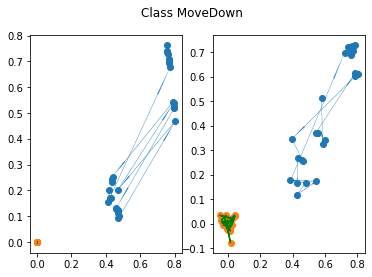

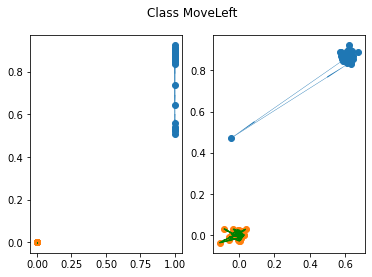

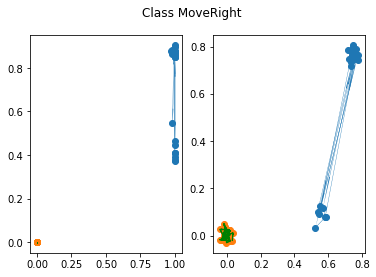

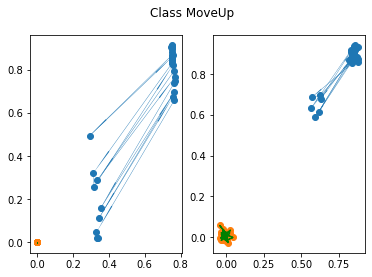

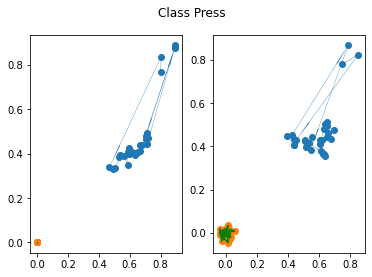

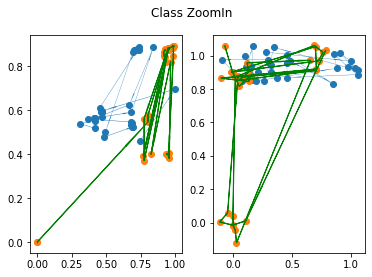

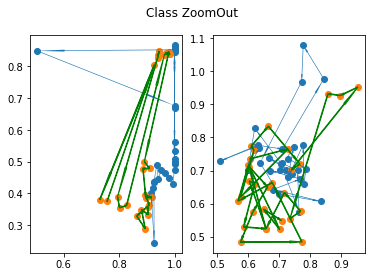

In [27]:
def plot_track(verts, ax, **kw_args):
    for xy0, xy1 in zip(verts[:-1], verts[1:]):
        patch = Arrow(*xy0, *(xy1 - xy0), **kw_args)
        ax.add_patch(patch)

for gesture in hand_gesture_list:
    
    _model = output_y == gesture
    _x = input_x[_model]
    
    L, R = _x[0, :, :2],_x[0, :, 2:]

    figure, (ax, ax2) = plt.subplots(ncols=2)
    plot_track(L, ax=ax, fill=True, width=0.01)
    plot_track(R, ax=ax, fill=True, color='green', width=0.01)

    ax.scatter(L[:, 0], L[:, 1])
    ax.scatter(R[:, 0], R[:, 1])

    s, z = sample_model(models[hand_gesture_list.index(gesture)], L.shape[0])
    Ls, Rs = s[:, :2], s[:, 2:]

    plot_track(Ls, ax=ax2, fill=True, width=0.01)
    plot_track(Rs, ax=ax2, fill=True, color='green', width=0.01)

    ax2.scatter(Ls[:, 0], Ls[:, 1])
    ax2.scatter(Rs[:, 0], Rs[:, 1])

    figure.suptitle('Class {}'.format(gesture))
    plt.show()
#     figure.savefig('{}.png'.format(gesture))